In [ ]:
import numpy as np
from scipy import ndimage
from skimage import color, io
import time
import matplotlib.pyplot as plt
from skimage import measure
from skimage import feature
import scipy.signal as signal
import scipy.ndimage as nd

In [ ]:
#Normalizacja
def normalize(image):
    return (image - np.min(image))/(np.max(image) - np.min(image))

#Filtr gaussaa
def gaussian_smoothing(image, sigma):
  return nd.gaussian_filter(image, sigma)

#Obliczanie magnitudy oraz kątu gradientów
def magnitude_angle(image):
    x_mask = np.array([[-1, 0, 1],
                       [-2, 0, 2], 
                       [-1, 0, 1]])
    y_mask = np.array([[1, 2, 1], 
                       [0, 0, 0], 
                       [-1, -2, -1]])
    
    #Obliczanie gradnietów x i y za pomocą maski sobela
    grad_x = ndimage.filters.convolve(image, x_mask)
    grad_y = ndimage.filters.convolve(image, y_mask)
    
    #Magnituda
    mag = np.sqrt(grad_x**2 + grad_y**2)
    #Kąt
    ang = np.arctan2(grad_y, grad_x)

    return mag,ang



def non_max_suppression(image, angle):
    #Tworzymy pustą tablice i w gradiencie kątów wartości ujemny przesuwanmy o 180 stopni
    nms = np.zeros(image.shape)
    angle[angle < 0] += np.pi

    #Sprawdzamy czy w konkretnych pixelach wartości kątów są zawarte w niżej zadanych przedziałach
    #Jeśli tak to zapisujemy wartości obok, w zależności od ich kąta
    for i in range(1,image.shape[0]-1):
        for j in range(1,image.shape[1]-1):
              tmp1 = 1
              tmp2 = 1
                
              #0 stopni
              if (0 <= angle[i,j] < np.pi/8) or (np.pi - np.pi/8 <= angle[i,j] <= np.pi):
                tmp1 = image[i, j+1]
                tmp2 = image[i, j-1]
              #45 stopni
              elif (np.pi/8 <= angle[i,j] < np.pi/4 + np.pi/8):
                tmp1 = image[i+1, j-1]
                tmp2 = image[i-1, j+1]
              #90 stopni
              elif (np.pi/4 + np.pi/8 <= angle[i,j] < np.pi/2 + np.pi/8):
                tmp1 = image[i+1, j]
                tmp2 = image[i-1, j]
              #135 stopni
              elif (np.pi/2 + np.pi/8 <= angle[i,j] < np.pi - np.pi/8):
                tmp1 = image[i-1, j-1]
                tmp2 = image[i+1, j+1]

              #Jeśli wartości "sąsiedzkie" są większe od aktualnego pixela to dopisujemy do brzegów
              if (image[i,j] >= tmp1) and (image[i,j] >= tmp2):
                  nms[i,j] = image[i,j]

    return nms

#Tworzenie dwóch masek na podstawie progu Otsu
def double_threshold(image,tresh):
    
    #wysoki i niski treshold
    highThreshold = tresh
    lowThreshold = tresh*0.5
    
    res = np.zeros(image.shape)
    
    #wartości które przypiszemy do maski słabej i mocnej
    weak = 0.5  
    strong = 1
    
    #miejsca gdzie obraz ma wartości większe od high treshold
    strongs = np.where(image >= highThreshold)
    #miejsca gdzie obraz ma wartości mniejsze od low treshold
    zeros = np.where(image < lowThreshold)
    
    #miejsca gdzie wartości znajdują się pomiędzy tamtymi tresholdami
    weaks = np.where((image <= highThreshold) & (image >= lowThreshold))
    
    #zapisujemy na obrazie słabe i mocne wartości 
    res[strongs] = strong
    res[weaks] = weak
    
    return res, weak, strong


def hysteresis(image, weak, strong): 
  #iterujemy przez cały obraz
    for i in range(1, image.shape[0]-1):
        for j in range(1, image.shape[1]-1):
          #sprawdzamy czy pixel ma wartość słabą
            if (image[i,j] == weak):
              for k in [-1,0,1]:
                for l in [-1,0,1]:
                  if k != 0 and l != 0:
                    #Jeśli ma to sprawdzamy czy w jego sąsiedztwie jest pixel o wartości silnej jeśli tak to dajmy mu wartosć 1 
                    if image[i+k,j+l] == strong:
                        image[i, j] = 1
                    #Jeśli nie to zerujemy go
                    else:
                        image[i, j] = 0
    return image

def otsu_threshold(image,bins_no=256):
  
  #Tworzymy histogram i biny
  hist, bins = np.histogram(np.ndarray.flatten(image), bins=bins_no)

  #Obliczamy środki binów
  bin_mids = (bins[:-1] + bins[1:]) / 2.

  #Zliczamy ilości pixeli 
  weight1 = np.cumsum(hist)
  weight2 = np.cumsum(hist[::-1])[::-1]

  #Zliczamy średnie
  mean1 = np.cumsum(hist * bin_mids) / weight1
  mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]

  #obliczamy wariancję klas
  inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

  # Maximize the inter_class_variance function val
  index_of_max_val = np.argmax(inter_class_variance)
  threshold = bin_mids[:-1][index_of_max_val]

  return threshold


In [ ]:
def canny(image, sigma=1):
    """
    1) Dokonaj filtracji obrazu filtrem Gaussa o zadanej sigmie
    2) Wyznacz przybliżenie gradientu (jego magnitude oraz kąt) za pomocą filtru Sobela
    3) Przeprowadź "non_maximum_supression" korzystając z magnitudy i kąta gradientu, wyznaczając tym samym potencjalnie krawędzie.
    4) Dokonaj podwójnego progowania potencjalnych krawędzi aby wyznaczyć krawędzie silne oraz krawędzie słabe.
    5) Przeprowadz histereze krawedzi.
    """
    image = normalize(image)
    copy = image.copy()
    smooth = gaussian_smoothing(image,sigma)
    mag,ang = magnitude_angle(smooth)
    nms = non_max_suppression(mag,ang)
    res, weak, strong = double_threshold(nms,otsu_threshold(copy))
    edges = hysteresis(res,weak,strong)
    
    return edges

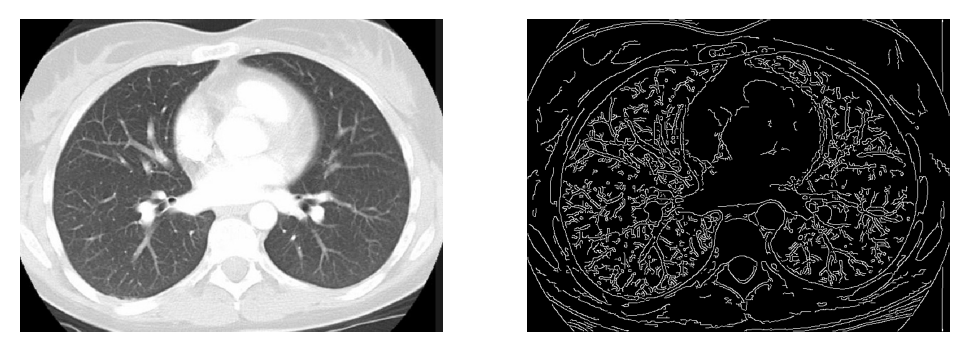

In [ ]:
# y_size, x_size = 256, 256
# image = np.zeros((y_size, x_size))
# image[100:200, 100:200] = 1
# image = image + np.random.randn(y_size, x_size)*0.02

image = color.rgb2gray(io.imread("CT_lungs.png"))

skimage_canny = feature.canny(image)

plt.figure(dpi=200)
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(skimage_canny, cmap='gray')
plt.axis('off')
plt.show()

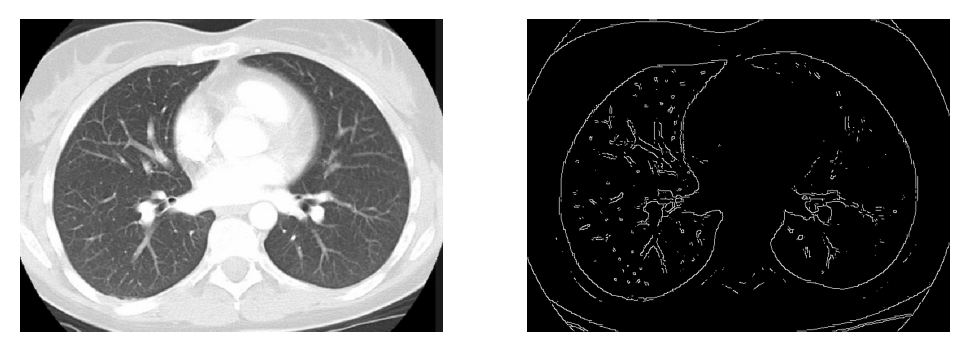

In [ ]:
my_canny = canny(image,0.5)

plt.figure(dpi=200)
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(my_canny, cmap='gray')
plt.axis('off')
plt.show()

(-0.5, 675.5, 499.5, -0.5)

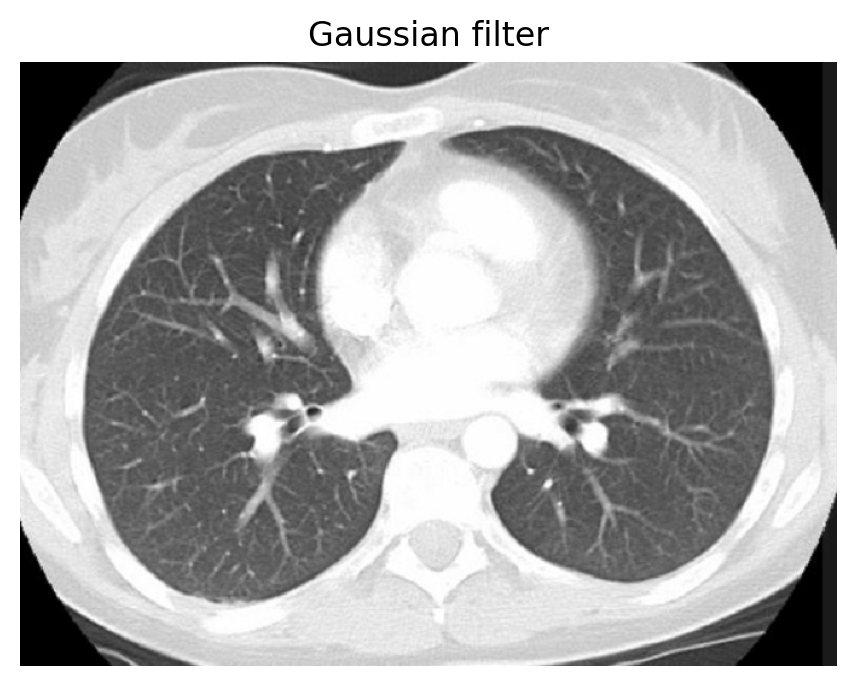

In [ ]:
image = normalize(image)
copy = image.copy()
smooth = gaussian_smoothing(image,0.5)

plt.figure(dpi=200)
plt.imshow(smooth, cmap='gray')
plt.title("Gaussian filter")
plt.axis('off')

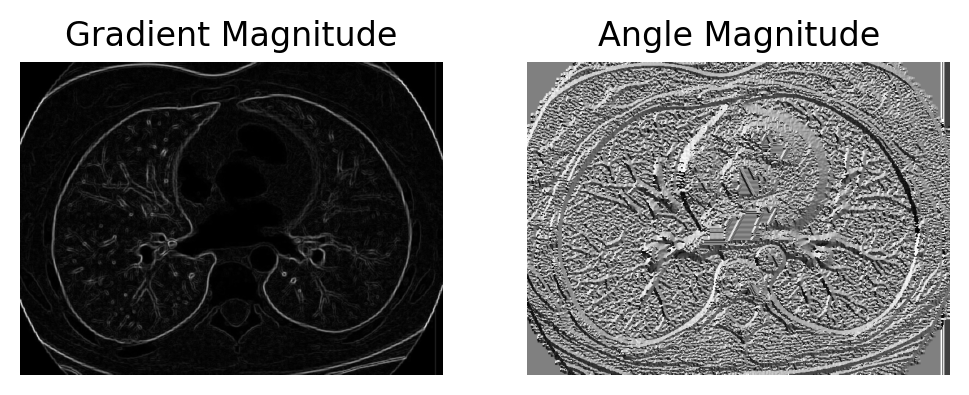

In [ ]:
mag,ang = magnitude_angle(smooth)

plt.figure(dpi=200)
plt.subplot(1, 2, 1)
plt.imshow(mag, cmap='gray')
plt.title("Gradient Magnitude")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(ang, cmap='gray')
plt.title("Angle Magnitude")
plt.axis('off')
plt.show()

(-0.5, 675.5, 499.5, -0.5)

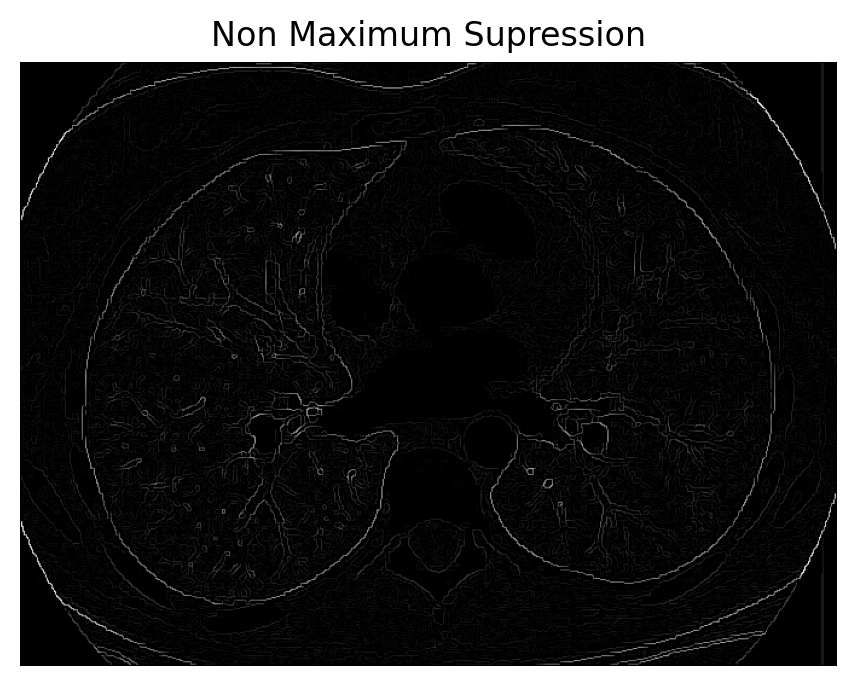

In [ ]:
nms = non_max_suppression(mag,ang)

plt.figure(dpi=200)
plt.imshow(nms, cmap='gray')
plt.title("Non Maximum Supression")
plt.axis('off')

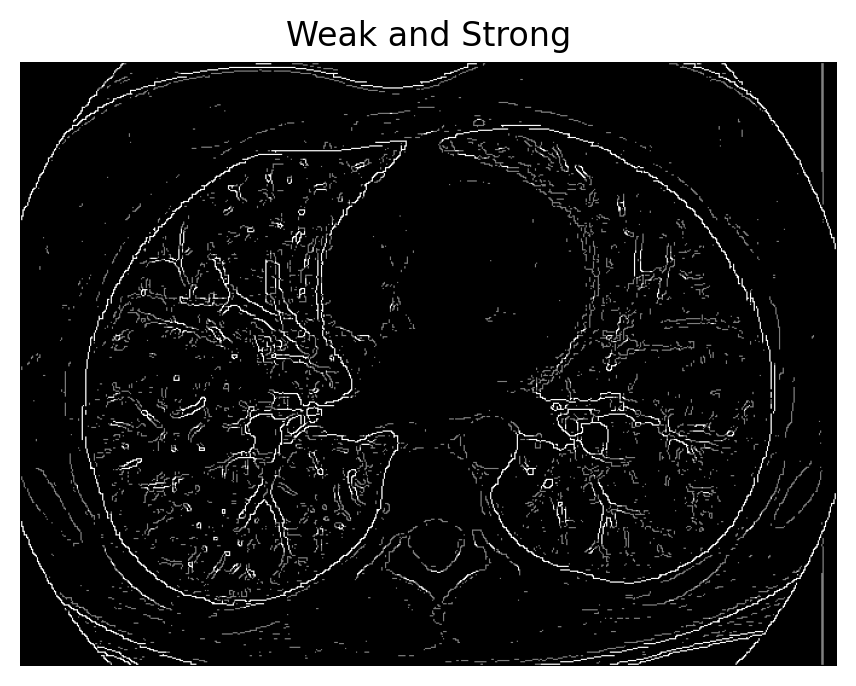

In [ ]:
res, weak, strong = double_threshold(nms,otsu_threshold(copy))


plt.figure(dpi=200)
plt.imshow(res, cmap='gray')
plt.title("Weak and Strong")
plt.axis('off')
plt.show()

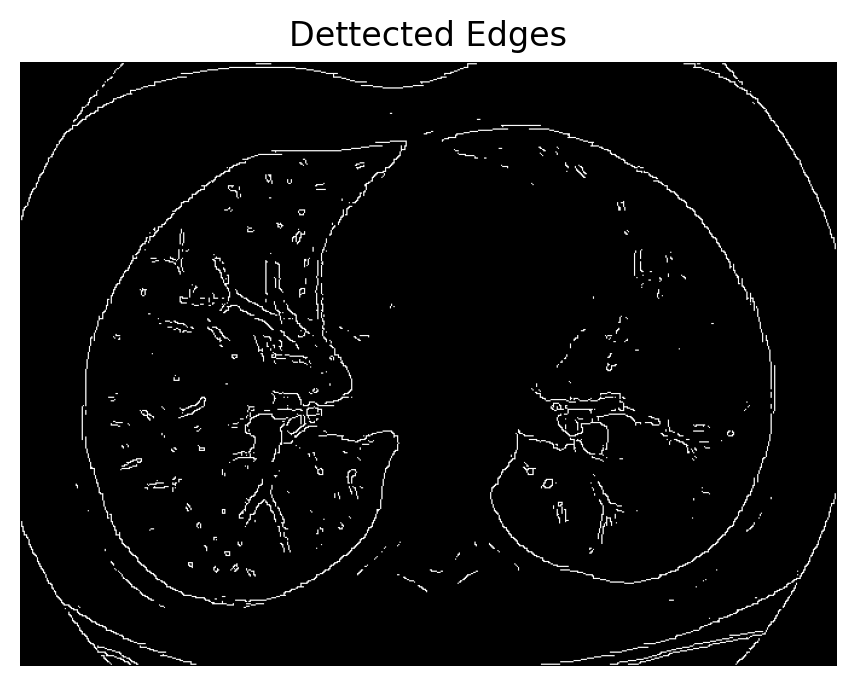

In [ ]:
edges = hysteresis(res,weak,strong)

plt.figure(dpi=200)
plt.imshow(edges, cmap='gray')
plt.title("Dettected Edges")
plt.axis('off')
plt.show()